# PW1 - Handwritten character recognition


In [12]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Laure Monfraix"
assert your_name

In [13]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [15]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [16]:
root_dir = './data/MNIST/'

### YOUR CODE HERE ###
from torchvision import datasets, transforms

transform = transforms.ToTensor()

trainset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)

testset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

60000 examples in the train set
10000 examples in the test set
Label: 5


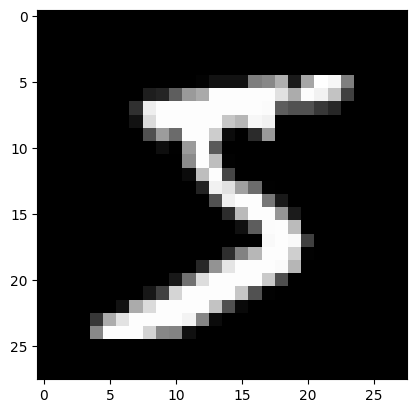

In [17]:
### YOUR CODE HERE ###

print(f'{len(trainset)} examples in the train set') # 60 000 examples
print(f'{len(testset)} examples in the test set') # 10 000 examples

# First image and label
image, label = trainset[0]

plt.imshow(image.squeeze(), cmap = 'gray')
print('Label:', label)

In [18]:
### YOUR CODE HERE ###

# Input dimension

image, label = trainset[0]
print(f'Input dimension: {image.shape}, Label: {label}')

Input dimension: torch.Size([1, 28, 28]), Label: 5


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

In [19]:
import torch.nn.functional as F

def preprocess(image):
    # Downsample the image to 7x7 using average pooling
    downsampled = F.avg_pool2d(image.unsqueeze(0), kernel_size=4).squeeze(0)
    flattened = downsampled.view(-1)
    return flattened

Again, use matplotlib to visualize an example of downsampling

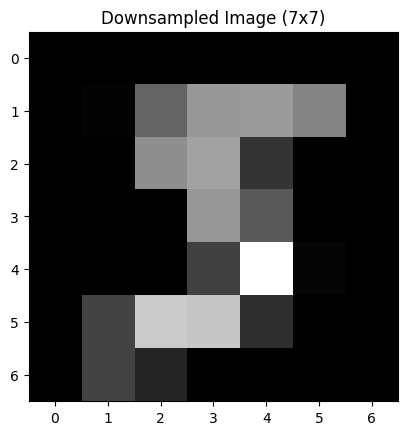

In [20]:
### YOUR CODE HERE ###
# Downsample the image 
downsampled_image = preprocess(image)

# Reshape the downsampled image to 7x7
downsampled_image_reshaped = downsampled_image.view(7, 7)

# Plot the downsampled image
plt.imshow(downsampled_image_reshaped, cmap='gray')
plt.title("Downsampled Image (7x7)")
plt.show()

In [21]:
### YOUR ( MODEL / PREPROCESSING ) CODE HERE ###
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x
    

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [22]:
### YOUR CODE HERE ###
criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [23]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # Preprocess the data
        data = torch.stack([preprocess(img) for img in data])
        # Forward pass
        output = model(data)
        # Compute loss
        loss = criterion(output, target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    accuracy = 100. * correct / total
    print(f"Train Epoch: {epoch + 1} Accuracy: {accuracy:.2f}%")
    return optimizer, accuracy

def test(model, preprocess):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Preprocess the data
            data = torch.stack([preprocess(img) for img in data])
            # Forward pass
            output = model(data)
            # Compute accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [24]:
### YOUR CODE HERE ###
# Model
input_dim = 7 * 7  # Flattened 7x7 image
output_dim = 10    # Number of classes

model = LinearModel(input_dim, output_dim).to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Training
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model, epoch, preprocess, optimizer)
    test_accuracy = test(model, preprocess)
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Train Epoch: 1 Accuracy: 82.26%
Test Accuracy: 87.02%
Epoch 1/2, Train Accuracy: 82.26%, Test Accuracy: 87.02%
Train Epoch: 2 Accuracy: 86.26%
Test Accuracy: 87.59%
Epoch 2/2, Train Accuracy: 86.26%, Test Accuracy: 87.59%


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [46]:
### YOUR CODE HERE ###
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, width, depth):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(width, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Create a 3-layer MLP with width 100
width = 100
depth = 3
mlp_model = MLP(input_dim, output_dim, width, depth).to(device)


In [53]:
NUM_EPOCH = 5

optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.1, momentum=0.9)

# Training the MLP model
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(mlp_model, epoch, preprocess, optimizer) 
    test_accuracy = test(mlp_model, preprocess)  
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch: 1 Accuracy: 82.94%
Test Accuracy: 91.91%
Epoch 1/5, Train Accuracy: 82.94%, Test Accuracy: 91.91%
Train Epoch: 2 Accuracy: 92.65%
Test Accuracy: 92.89%
Epoch 2/5, Train Accuracy: 92.65%, Test Accuracy: 92.89%
Train Epoch: 3 Accuracy: 94.00%
Test Accuracy: 94.79%
Epoch 3/5, Train Accuracy: 94.00%, Test Accuracy: 94.79%
Train Epoch: 4 Accuracy: 94.55%
Test Accuracy: 94.94%
Epoch 4/5, Train Accuracy: 94.55%, Test Accuracy: 94.94%
Train Epoch: 5 Accuracy: 95.06%
Test Accuracy: 94.83%
Epoch 5/5, Train Accuracy: 95.06%, Test Accuracy: 94.83%


### Add Dropout

We test the addition of dropout layers after each hidden MLP layer to limit overlearning. The aim is to improve the generalization capacity of the model and increase its accuracy on the test set.

In [ ]:
# Define the MLP model with dropout
class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim, width, depth, dropout_p=0.5):
        super(MLP2, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))  # dropout after first layer

        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))  # dropout after each hiddden layer

        layers.append(nn.Linear(width, output_dim)) 
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
width = 100
depth = 3
dropout_p = 0.5

mlp_model_dropout = MLP2(input_dim, output_dim, width, depth, dropout_p=dropout_p).to(device)


In [26]:
NUM_EPOCH = 5

optimizer = torch.optim.SGD(mlp_model_dropout.parameters(), lr=0.1, momentum=0.9)

# Training the MLP model
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(mlp_model_dropout, epoch, preprocess, optimizer) 
    test_accuracy = test(mlp_model_dropout, preprocess)  
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch: 1 Accuracy: 64.56%
Test Accuracy: 85.60%
Epoch 1/5, Train Accuracy: 64.56%, Test Accuracy: 85.60%
Train Epoch: 2 Accuracy: 77.58%
Test Accuracy: 87.69%
Epoch 2/5, Train Accuracy: 77.58%, Test Accuracy: 87.69%
Train Epoch: 3 Accuracy: 78.33%
Test Accuracy: 89.84%
Epoch 3/5, Train Accuracy: 78.33%, Test Accuracy: 89.84%
Train Epoch: 4 Accuracy: 79.75%
Test Accuracy: 89.30%
Epoch 4/5, Train Accuracy: 79.75%, Test Accuracy: 89.30%
Train Epoch: 5 Accuracy: 80.11%
Test Accuracy: 89.90%
Epoch 5/5, Train Accuracy: 80.11%, Test Accuracy: 89.90%


The addition of the Dropout results in a test accuracy of 89.9%, slightly lower than that obtained with the classic MLP, which may be explained by sub-optimization of the model parameters (for example, a dropout rate that is too high or an insufficient number of epochs to compensate for the additional regularization).

In [ ]:
import torch.optim as optim

class MLP_opti(nn.Module):
    def __init__(self, input_dim, output_dim, width, depth, dropout_p):
        super(MLP_opti, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(width, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Hyperparameters to test
learning_rates = [0.1, 0.01, 0.001]
dropout_rates = [0.3, 0.5, 0.7]

best_accuracy = 0
best_params = {}

# Loop through hyperparameters
for lr in learning_rates:
    for dropout_p in dropout_rates:
        print(f"\nTesting lr={lr}, dropout_p={dropout_p}")
        
        model = MLP_opti(input_dim, output_dim, width=100, depth=3, dropout_p=dropout_p).to(device)
        
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        # Training
        for epoch in range(5):  
            optimizer, train_accuracy = train(model, epoch, preprocess, optimizer)
        
        # Evaluation
        test_accuracy = test(model, preprocess)
        
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        
        # Save the best parameters based on test accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params = {'learning_rate': lr, 'dropout_p': dropout_p}

print("\nBest Hyperparameters found:")
print(best_params)
print(f"Best Test Accuracy: {best_accuracy:.2f}%")



Testing lr=0.1, dropout_p=0.3
Train Epoch: 1 Accuracy: 75.61%
Train Epoch: 2 Accuracy: 87.36%
Train Epoch: 3 Accuracy: 88.82%
Train Epoch: 4 Accuracy: 89.47%
Train Epoch: 5 Accuracy: 90.04%
Test Accuracy: 92.94%
Test Accuracy: 92.94%

Testing lr=0.1, dropout_p=0.5
Train Epoch: 1 Accuracy: 64.58%
Train Epoch: 2 Accuracy: 77.25%
Train Epoch: 3 Accuracy: 79.31%
Train Epoch: 4 Accuracy: 79.94%
Train Epoch: 5 Accuracy: 80.55%
Test Accuracy: 90.22%
Test Accuracy: 90.22%

Testing lr=0.1, dropout_p=0.7
Train Epoch: 1 Accuracy: 29.59%
Train Epoch: 2 Accuracy: 24.13%
Train Epoch: 3 Accuracy: 18.82%
Train Epoch: 4 Accuracy: 16.13%
Train Epoch: 5 Accuracy: 17.38%
Test Accuracy: 24.57%
Test Accuracy: 24.57%

Testing lr=0.01, dropout_p=0.3
Train Epoch: 1 Accuracy: 46.58%
Train Epoch: 2 Accuracy: 81.00%
Train Epoch: 3 Accuracy: 86.62%
Train Epoch: 4 Accuracy: 88.59%
Train Epoch: 5 Accuracy: 89.82%
Test Accuracy: 93.36%
Test Accuracy: 93.36%

Testing lr=0.01, dropout_p=0.5
Train Epoch: 1 Accuracy: 38

Despite the optimization of hyperparameters, the addition of Dropout does not bring any significant gain in performance over the MLP without Dropout. This suggests that the base MLP was not strongly prone to overfitting on this dataset, probably due to the size of the dataset or the nature of the task.

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  
        self.relu = nn.ReLU() 
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        self.flatten = nn.Flatten()  
        self.fc = nn.Linear(8 * 13 * 13, 10) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Model
conv_model = ConvModel().to(device)


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [ ]:
# Conv model with 2 layers
NUM_EPOCH = 5 

optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.1, momentum=0.9)

# Training 
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(conv_model, epoch, lambda x: x, optimizer)
    test_accuracy = test(conv_model, lambda x: x)
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch: 1 Accuracy: 94.37%
Test Accuracy: 97.39%
Epoch 1/5, Train Accuracy: 94.37%, Test Accuracy: 97.39%
Train Epoch: 2 Accuracy: 97.34%
Test Accuracy: 97.70%
Epoch 2/5, Train Accuracy: 97.34%, Test Accuracy: 97.70%
Train Epoch: 3 Accuracy: 97.88%
Test Accuracy: 97.64%
Epoch 3/5, Train Accuracy: 97.88%, Test Accuracy: 97.64%
Train Epoch: 4 Accuracy: 98.05%
Test Accuracy: 97.73%
Epoch 4/5, Train Accuracy: 98.05%, Test Accuracy: 97.73%
Train Epoch: 5 Accuracy: 98.29%
Test Accuracy: 97.72%
Epoch 5/5, Train Accuracy: 98.29%, Test Accuracy: 97.72%


In [ ]:
# Conv model with 3 layers
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  
        self.relu = nn.ReLU()  # ReLU activation
        self.maxpool = nn.MaxPool2d(kernel_size=2)  
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(8 * 13 * 13, h) 
        self.fc2 = nn.Linear(h, h)  
        self.fc3 = nn.Linear(h, 10) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model
h = 100  # Hidden neurons
conv_deep_model = ConvDeepModel(h=h).to(device)

optimizer = torch.optim.SGD(conv_deep_model.parameters(), lr=0.1, momentum=0.9)

# Training 
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(conv_deep_model, epoch, lambda x: x, optimizer)
    test_accuracy = test(conv_deep_model, lambda x: x)
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch: 1 Accuracy: 91.89%
Test Accuracy: 96.57%
Epoch 1/5, Train Accuracy: 91.89%, Test Accuracy: 96.57%
Train Epoch: 2 Accuracy: 97.65%
Test Accuracy: 97.11%
Epoch 2/5, Train Accuracy: 97.65%, Test Accuracy: 97.11%
Train Epoch: 3 Accuracy: 98.18%
Test Accuracy: 97.74%
Epoch 3/5, Train Accuracy: 98.18%, Test Accuracy: 97.74%
Train Epoch: 4 Accuracy: 98.60%
Test Accuracy: 97.98%
Epoch 4/5, Train Accuracy: 98.60%, Test Accuracy: 97.98%
Train Epoch: 5 Accuracy: 98.83%
Test Accuracy: 98.09%
Epoch 5/5, Train Accuracy: 98.83%, Test Accuracy: 98.09%


Logically, with 3 layers, test accuracy increases.

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

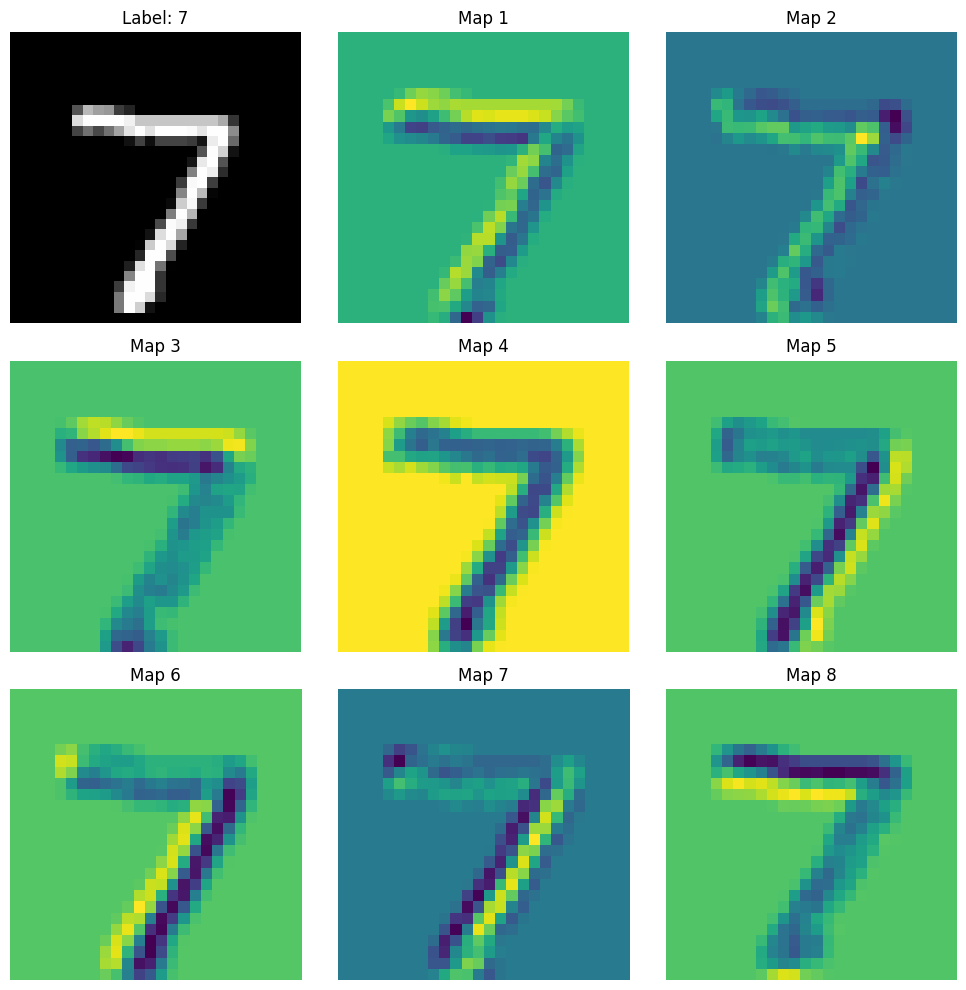

In [55]:
### YOUR CODE HERE ###
image, label = testset[0]
image = image.unsqueeze(0).to(device)

output = conv_model.conv1(image)

plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(image.cpu().squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')

for i in range(8):
    plt.subplot(3, 3, i + 2)
    plt.imshow(output[0, i].cpu().detach(), cmap='viridis')
    plt.title(f"Map {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(d, h)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h, d)

    def forward(self, x):
        residual = x  # input for the residual connection
        out = self.fc1(x)  
        out = self.relu(out)  
        out = self.fc2(out)  
        out += residual  # residual connection
        return out

In [58]:
class ConvResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return self.relu(out)

In a convolutional block, the out_channels parameter determines the number of filters learned, playing a role equivalent to the number of neurons in a hidden layer of an MLP. The higher out_channels is, the more varied and complex patterns the model can detect.

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [ ]:
class ResidualConvNet(nn.Module):
    def __init__(self, num_residual_blocks, in_channels=1, out_channels=8, kernel_size=3, hidden_dim=100, num_classes=10):
        super(ResidualConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.residual_blocks = nn.Sequential(
            *[ConvResidualBlock(out_channels, out_channels) for _ in range(num_residual_blocks)]
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(out_channels * 14 * 14, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.residual_blocks(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Model
num_residual_blocks = 3  
residual_conv_net = ResidualConvNet(num_residual_blocks=num_residual_blocks).to(device)

# Optimizer
optimizer = torch.optim.SGD(residual_conv_net.parameters(), lr=0.1, momentum=0.9)

# Training
for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(residual_conv_net, epoch, lambda x: x, optimizer)
    test_accuracy = test(residual_conv_net, lambda x: x)
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch: 1 Accuracy: 94.38%
Test Accuracy: 96.93%
Epoch 1/5, Train Accuracy: 94.38%, Test Accuracy: 96.93%
Train Epoch: 2 Accuracy: 97.02%
Test Accuracy: 97.33%
Epoch 2/5, Train Accuracy: 97.02%, Test Accuracy: 97.33%
Train Epoch: 3 Accuracy: 97.39%
Test Accuracy: 97.80%
Epoch 3/5, Train Accuracy: 97.39%, Test Accuracy: 97.80%
Train Epoch: 4 Accuracy: 97.81%
Test Accuracy: 97.81%
Epoch 4/5, Train Accuracy: 97.81%, Test Accuracy: 97.81%
Train Epoch: 5 Accuracy: 97.79%
Test Accuracy: 97.85%
Epoch 5/5, Train Accuracy: 97.79%, Test Accuracy: 97.85%


Yes, the accuracy of the two-layer model can be matched or exceeded by adding layers, especially with residual blocks. Without them, depth often leads to a drop in performance due to the vanishing gradient, which blocks learning. Residual blocks overcome this problem by facilitating gradient propagation.

Yes, this is borne out in experiments: despite similar performance (test accuracy ≈ 94-95%), an MLP with 3 hidden layers of width 100 uses far more parameters than a lighter ResNet. Indeed, with only 2 convolutional layers and residual blocks, similar test accuracy results are achieved, while model complexity is reduced.

In [62]:
from torchinfo import summary

info = summary(residual_conv_net, input_size=(1, 1, 28, 28), depth=3)
print(f"Total trainable parameters for ResNet: {info.total_params:,}")

info2 = summary(mlp_model, input_size=(1, 49))
print(f"Total trainable parameters for MLP: {info2.total_params:,}")


Total trainable parameters for ResNet: 19,274
Total trainable parameters for MLP: 26,210


Both models achieve similar performance, but the ResNet uses only 19,274 parameters, compared with 26,210 for the MLP.

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [ ]:
### YOUR CODE HERE ###
# Initialization
n_batch = 4
n_classes = 10

# Random scores and labels
scores = torch.randn(n_batch, n_classes)
labels = torch.randint(0, n_classes, (n_batch,))

# nn.CrossEntropyLoss()
criterion_ce = nn.CrossEntropyLoss()
loss_ce = criterion_ce(scores, labels)

# nn.NLLLoss() and nn.LogSoftmax()
log_softmax = nn.LogSoftmax(dim=1)
nll_loss = nn.NLLLoss()
loss_nll_logsoftmax = nll_loss(log_softmax(scores), labels)

# nn.NLLLoss() and nn.Softmax()
softmax = nn.Softmax(dim=1)
loss_nll_softmax = nll_loss(torch.log(softmax(scores)), labels)


print(f"Loss using nn.CrossEntropyLoss(): {loss_ce.item()}")
print(f"Loss using nn.NLLLoss() and nn.LogSoftmax(): {loss_nll_logsoftmax.item()}")
print(f"Loss using nn.NLLLoss() and nn.Softmax(): {loss_nll_softmax.item()}")

# Outputs are the same

Loss using nn.CrossEntropyLoss(): 3.082906723022461
Loss using nn.NLLLoss() and nn.LogSoftmax(): 3.082906723022461
Loss using nn.NLLLoss() and nn.Softmax(): 3.0829062461853027


## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [ ]:
def ce(logits, targets):
    ### YOUR CODE HERE ###
    exp_logits = torch.exp(logits)
    softmax_probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)
    
    # True class
    true_class_probs = softmax_probs[range(len(targets)), targets]
    
    # Compute loss
    loss = -torch.mean(torch.log(true_class_probs))
    return loss

# Check the results
loss_custom = ce(scores, labels)
print(f"Loss using custom implementation: {loss_custom.item()}")
print(f"Loss using nn.CrossEntropyLoss(): {loss_ce.item()}")

Loss using custom implementation: 3.082906484603882
Loss using nn.CrossEntropyLoss(): 3.082906723022461


## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [72]:
### YOUR CODE HERE ###

scores_high_std = torch.randn(n_batch, n_classes) * 100
labels_high_std = torch.randint(0, n_classes, (n_batch,))

# nn.CrossEntropyLoss()
loss_ce_high_std = criterion_ce(scores_high_std, labels_high_std)
print(f"Loss using nn.CrossEntropyLoss(): {loss_ce_high_std.item()}")


# nn.NLLLoss() and nn.LogSoftmax()
loss_nll_logsoftmax_high_std = nll_loss(log_softmax(scores_high_std), labels_high_std)
print(f"Loss using nn.NLLLoss() and nn.LogSoftmax(): {loss_nll_logsoftmax_high_std.item()}")

# nn.NLLLoss() and nn.Softmax()

loss_nll_softmax_high_std = nll_loss(torch.log(softmax(scores_high_std)), labels_high_std)
print(f"Loss using nn.NLLLoss() and nn.Softmax(): {loss_nll_softmax_high_std.item()}")

# Custom implementation
loss_custom_high_std = ce(scores_high_std, labels_high_std)
print(f"Loss using custom implementation: {loss_custom_high_std.item()}")


Loss using nn.CrossEntropyLoss(): 100.24188232421875
Loss using nn.NLLLoss() and nn.LogSoftmax(): 100.24188232421875
Loss using nn.NLLLoss() and nn.Softmax(): inf
Loss using custom implementation: nan


When applying different cross-entropy calculation methods to very high Gaussian scores (standard deviation 100), only some remain stable. Methods using nn.CrossEntropyLoss() directly or nn.NLLLoss() combined with nn.LogSoftmax() give identical and stable results, as they incorporate the log-sum-exp trick, which prevents overflows when calculating exponentials. On the other hand, methods based on Softmax followed by log, or a naive implementation using torch.exp() like the one initially proposed, return inf or nan, as exponentials of very large values exceed the capacity of floats.

Re-implement a stable version of cross-entropy.

In [ ]:
def stable_ce(logits, targets):
    ### YOUR CODE HERE ###
    
    # Apply the log-sum-exp trick for stability
    max_logits = torch.max(logits, dim=1, keepdim=True).values
    logits_exp = logits - max_logits 
    log_probs = logits_exp - torch.log(torch.sum(torch.exp(logits_exp), dim=1, keepdim=True))
    
    # True classes
    true_class_log_probs = log_probs[range(len(targets)), targets]
    
    # Compute the loss
    loss = -torch.mean(true_class_log_probs)
    return loss


# Check the results

# classical CrossEntropyLoss 
criterion_ce = torch.nn.CrossEntropyLoss()
loss_ce = criterion_ce(scores_high_std, labels_high_std)

# random data 
scores_high_std = torch.randn(n_batch, n_classes) * 100
labels_high_std = torch.randint(0, n_classes, (n_batch,))

# custom CrossEntropyLoss 

loss_stable = stable_ce(scores_high_std, labels_high_std)
print(f"Loss using stable implementation: {loss_stable.item():.4f}")
print(f"Loss using nn.CrossEntropyLoss(): {loss_ce.item():.4f}")

Loss using stable implementation: 106.2891
Loss using nn.CrossEntropyLoss(): 100.2419
